### Libraries

In [4]:
import pandas as pd
import gzip
from io import BytesIO
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
from datetime import datetime

import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import gaussian_kde
import statsmodels.api as sm


pd.options.mode.chained_assignment = None

### Helper Functions

In [5]:
#function to convert data and time formats and create a column that contain both values in datetime format
def converti_data_ora(row):
    data_str = str(row['Data'])
    ora_str = str(row['Ora']-1)  # -1 because the range time is from 0 to 23 so ex. hour 1 corresponds to 00:00
    data_ora_str = data_str[:4] + '-' + data_str[4:6] + '-' + data_str[6:] + ' ' + ora_str + ':00:00'
    return datetime.strptime(data_ora_str, '%Y-%m-%d %H:%M:%S')


# Polynomial smoothing
def smooth_series(series, degree=2):
    y = series.values
    mask = ~np.isnan(y)
    coefs = Polynomial.fit(x[mask], y[mask], deg=degree)
    return coefs(x)

# LOESS smoothing 
def apply_loess(series, frac=0.3):
    lowess = sm.nonparametric.lowess # LOESS smoothing
    smoothed_values = lowess(series, series.index, frac=frac, return_sorted=False) # The series index is numeric and represents hours
    return smoothed_values

#### Reading the Data in

In [6]:
path = r'C:\Users\bartama\Desktop\PoliMi Stuff\Applied Statistics\Data\dataa\\'
file = 'ts_df.pkl.gz'

In [7]:
with gzip.open(path+file, 'rb') as f:
    loaded_df = pd.read_pickle(f)

### Filter df

In [8]:
# Getting 2023 Values

loaded_df['Data'] = pd.to_datetime(loaded_df['Data'], format='%Y%m%d')
loaded_df = loaded_df.loc[loaded_df['Data'].dt.year == 2023,:]

In [9]:
loaded_df = loaded_df.loc[loaded_df.ZonaMercato=='CALA;CNOR;CSUD;NORD;SARD;SICI;SUD;AUST;COAC;CORS;FRAN;GREC;SLOV;SVIZ;MALT;COUP;MONT;',:]


In [10]:
# Combine 'Data' and 'Ora' columns and convert to datetime

loaded_df['Data'] = pd.to_datetime(loaded_df['Data'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
loaded_df['Ora'] = (loaded_df['Ora'] - 1).astype(str).str.zfill(2) + ':00:00'
loaded_df['DataOra'] = pd.to_datetime(loaded_df['Data'] + ' ' + loaded_df['Ora'])

In [11]:
# rename columns to English

column_mapping = {'Data': 'Day', 'Ora': 'Hour',"Mercato":"Market", 'ZonaMercato': 'MarketArea', 'PrezzoZonale': 'ZonalPrice', 'Quantita': 'Quantity', 'Prezzo': 'Price', 'Tipo': 'Type', "DataOra": "Date"}

loaded_df.rename(columns=column_mapping, inplace=True)

### Preprocess

In [12]:
#loaded_df[['ZonalPrice', 'MarketArea']].drop_duplicates()
columns_wanted = ['Date', 'ZonalPrice', 'Quantity','Price']

In [23]:
bid = loaded_df.loc[loaded_df.Type == "BID",columns_wanted]

bid_df = bid.copy()
bid.Price = bid.Price *-1 ## for bid prices, take the negative of it
bid = bid.sort_values(by=['Price']).reset_index(drop = True) # sort in ascending way
bid['Cumulative Quantity'] = bid.Quantity.cumsum()

ask = loaded_df.loc[loaded_df.Type == "OFF",columns_wanted]
ask_df = ask.copy()
ask = ask.sort_values(by=['Price']).reset_index(drop = True)
ask['Cumulative Quantity'] = ask.Quantity.cumsum()


## PLOTTIN FOR INITIAL OVERVIEW

#### BID

KeyboardInterrupt: 

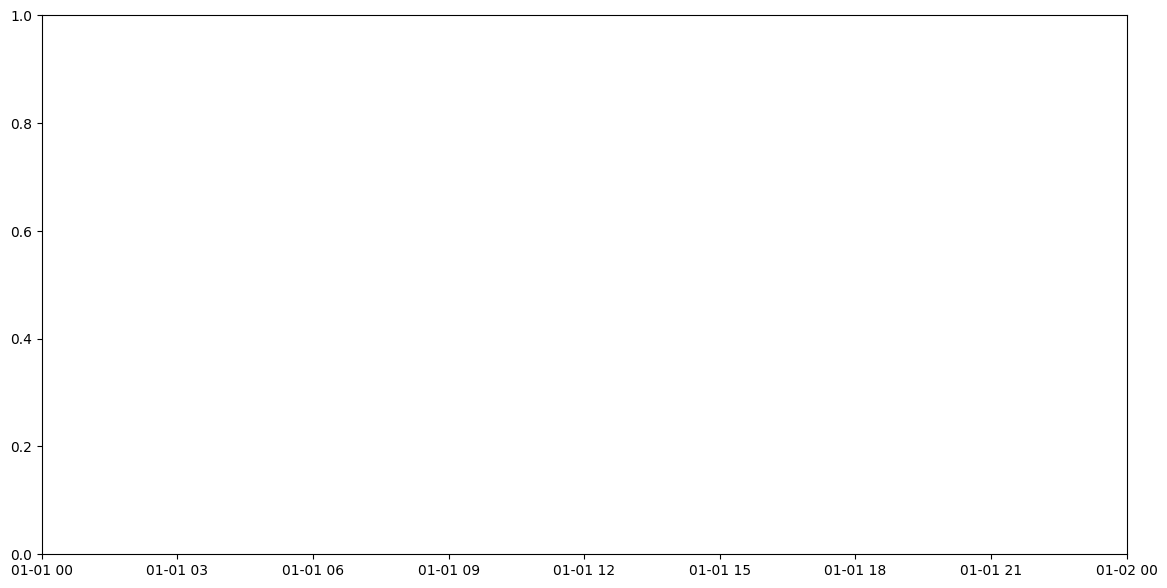

In [14]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='ZonalPrice', data=bid_df)
plt.title('Zonal Price Trend over Time')
plt.show()

In [24]:
# Extract hours and days of the week
bid_df['hour'] = bid_df['Date'].dt.hour
bid_df['day_week'] = bid_df['Date'].dt.dayofweek


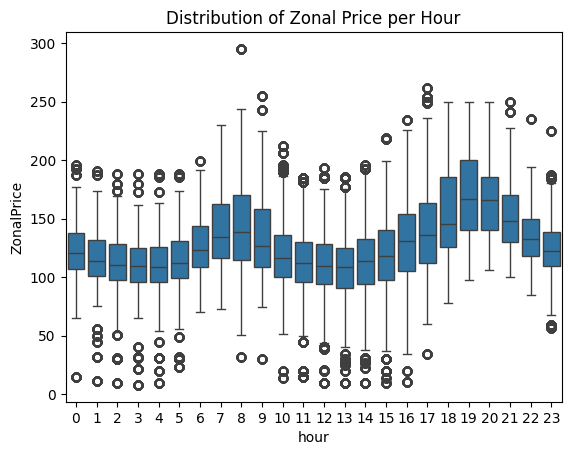

In [25]:
# Analysis for hours
sns.boxplot(x='hour', y='ZonalPrice', data=bid_df)
plt.title('Distribution of Zonal Price per Hour')
plt.show()

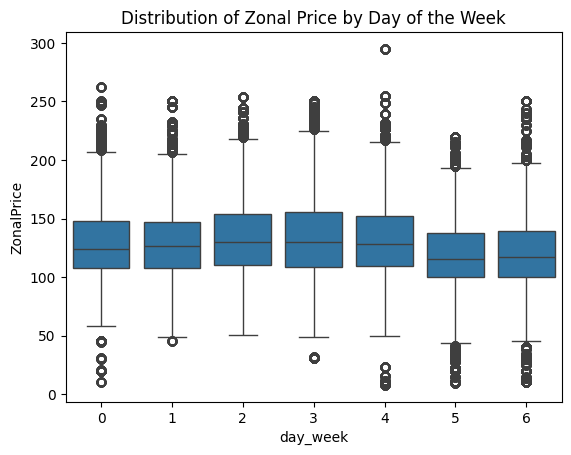

In [26]:
# Analysis by day of the week
sns.boxplot(x='day_week', y='ZonalPrice', data=bid_df)
plt.title('Distribution of Zonal Price by Day of the Week')
plt.show()

#### ASK

In [27]:
# Extract hours and days of the week
ask_df['hour'] = ask_df['Date'].dt.hour
ask_df['day_week'] = ask_df['Date'].dt.dayofweek


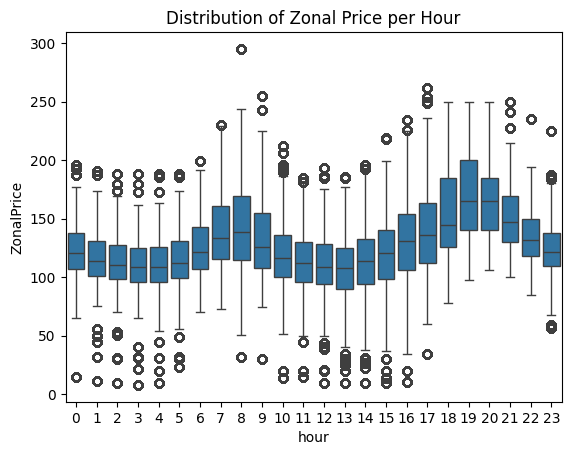

In [28]:
# Analysis for hours
sns.boxplot(x='hour', y='ZonalPrice', data=ask_df)
plt.title('Distribution of Zonal Price per Hour')
plt.show()

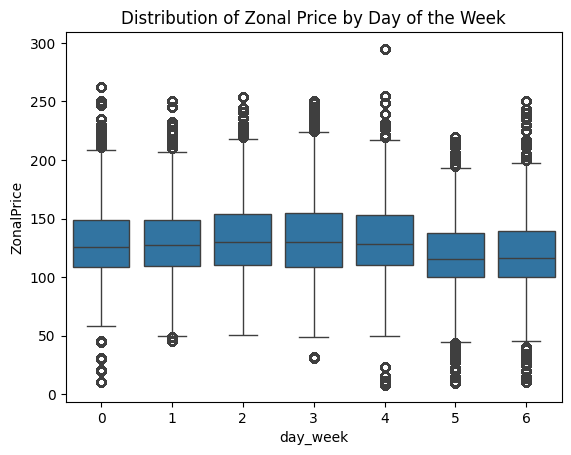

In [20]:
# Analysis by day of the week
sns.boxplot(x='day_week', y='ZonalPrice', data=ask_df)
plt.title('Distribution of Zonal Price by Day of the Week')
plt.show()

## BID:  AGGREGATING AND TAKING MEAN

In [29]:
bid_df.set_index('Date', inplace=True)
zonal_price_means = bid_df.groupby(by=[bid_df.index]).agg({'ZonalPrice': 'mean'}).rename(columns={'ZonalPrice': 'MeanZonalPrice'}).reset_index()

In [30]:
# Extract hours and days of the week
zonal_price_means['hour'] = zonal_price_means['Date'].dt.hour
zonal_price_means['day_week'] = zonal_price_means['Date'].dt.dayofweek

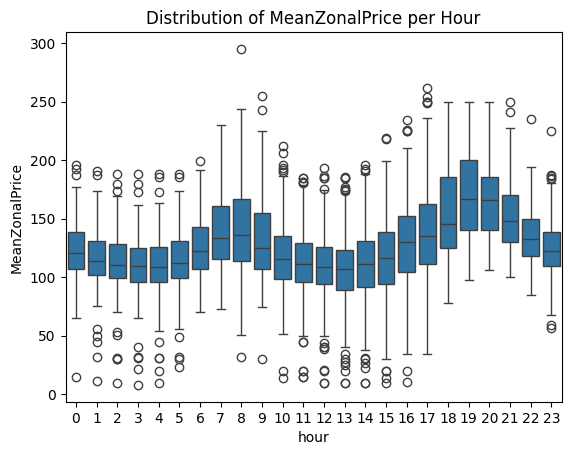

In [31]:
# Analysis for hours
sns.boxplot(x='hour', y='MeanZonalPrice', data=zonal_price_means)
plt.title('Distribution of MeanZonalPrice per Hour')
plt.show()

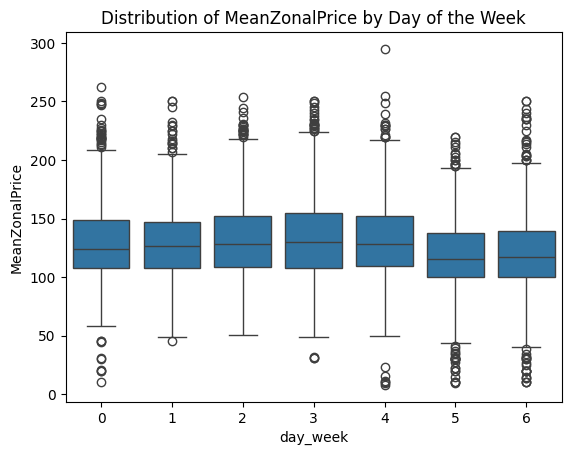

In [32]:
# Analysis by day of the week
sns.boxplot(x='day_week', y='MeanZonalPrice', data=zonal_price_means)
plt.title('Distribution of MeanZonalPrice by Day of the Week')
plt.show()

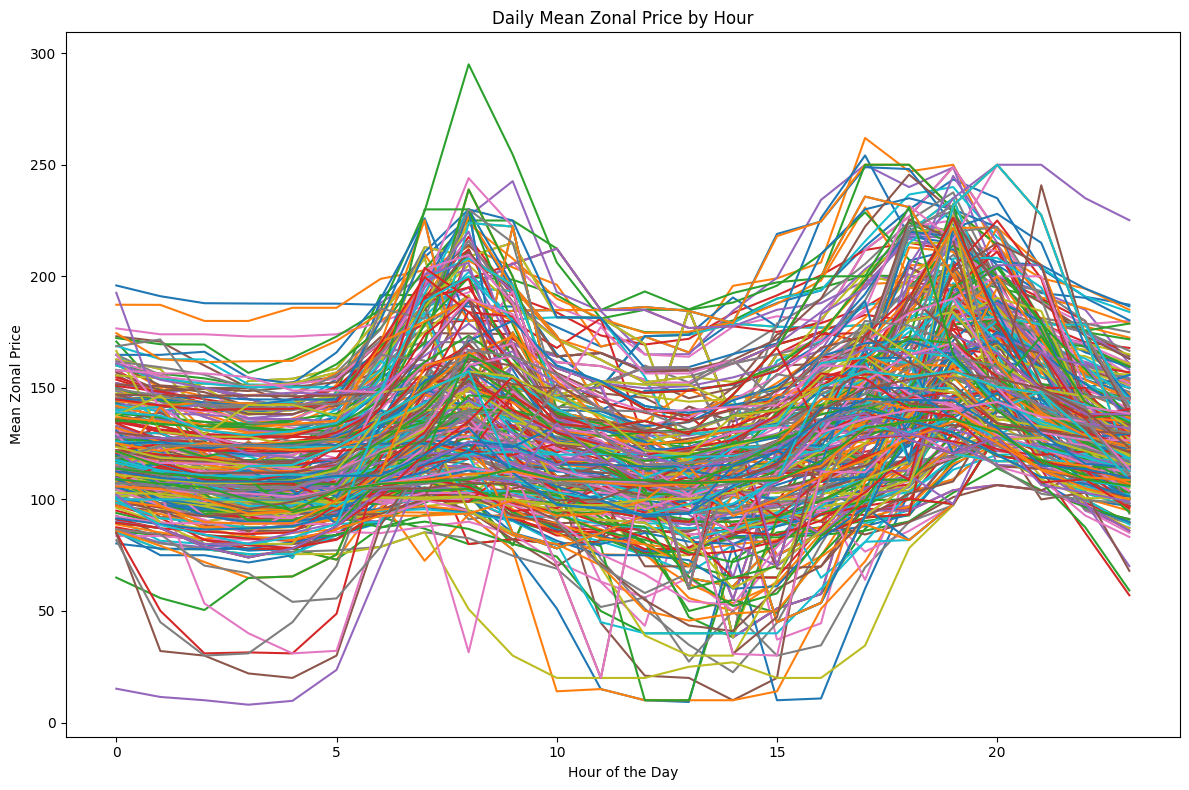

In [33]:
# Extract day from 'Date' to use it as a part of pivot
zonal_price_means['Day'] = zonal_price_means['Date'].dt.date

# Pivot the DataFrame to get days as columns and hours as rows
pivot_df = zonal_price_means.pivot(index='hour', columns='Day', values='MeanZonalPrice')
pivot_df.ffill(axis=1, inplace=True) #### I AM FILLING MY DATA IN based on previous day's same hour value


# Plotting
plt.figure(figsize=(12, 8))

for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=column)

plt.title('Daily Mean Zonal Price by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Zonal Price')
#plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.show()

## SMOOTHEN

In [34]:
x = np.arange(24)  # Hours

POLYNOMIAL

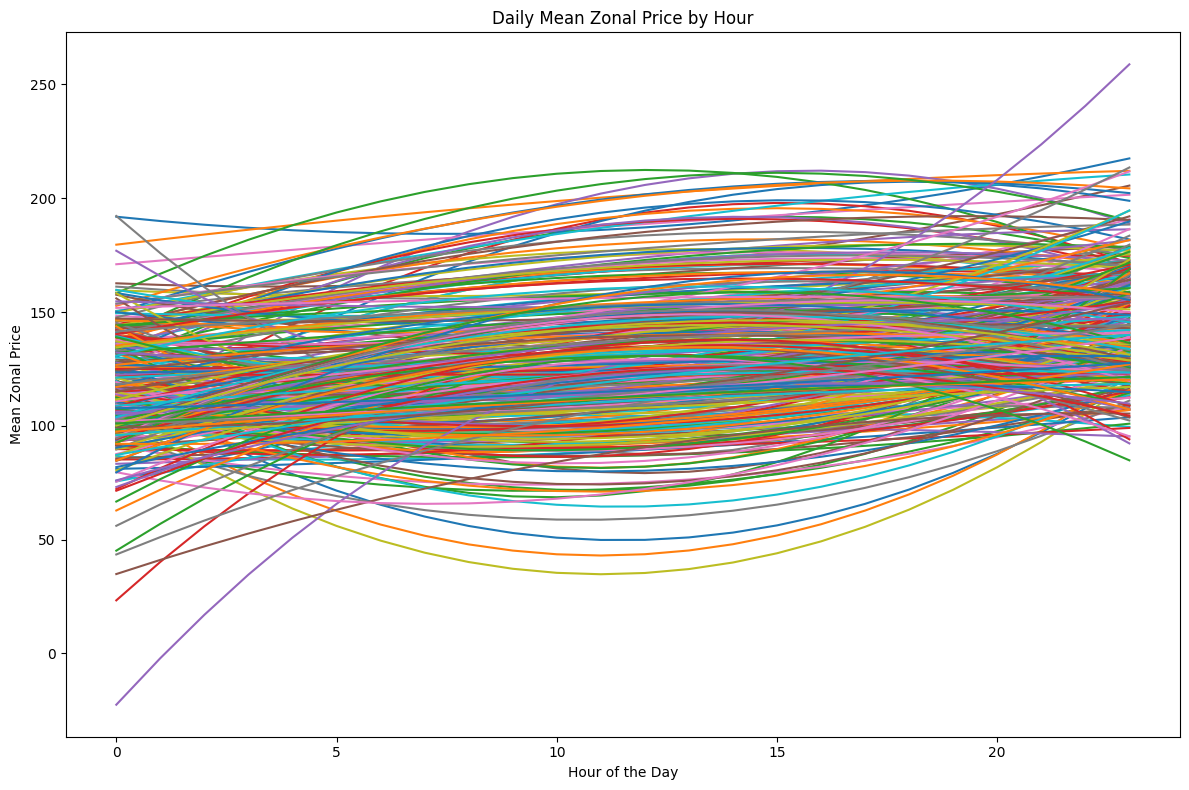

In [35]:
# Smoothing to each day's data
smoothed_data = pivot_df.apply(smooth_series, axis=0)

# Plotting
plt.figure(figsize=(12, 8))

for column in smoothed_data.columns:
    plt.plot(smoothed_data.index, smoothed_data[column], label=column)

plt.title('Daily Mean Zonal Price by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Zonal Price')
#plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Adjust layout
plt.tight_layout()

plt.show()

LOESS

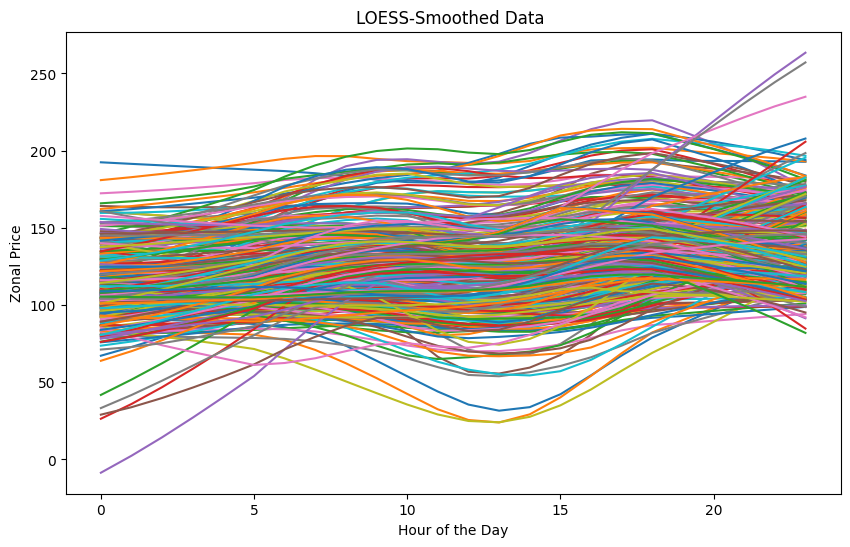

In [36]:
smoothed_df = pivot_df.apply(apply_loess, frac=0.5)  # Adjust frac as needed

# PLOT
plt.figure(figsize=(10, 6))
plt.plot(smoothed_df.index, smoothed_df, label='Smoothed with LOESS')
plt.title(f"LOESS-Smoothed Data ")
plt.xlabel('Hour of the Day')
plt.ylabel('Zonal Price')
plt.show()

## FPCA

### plots

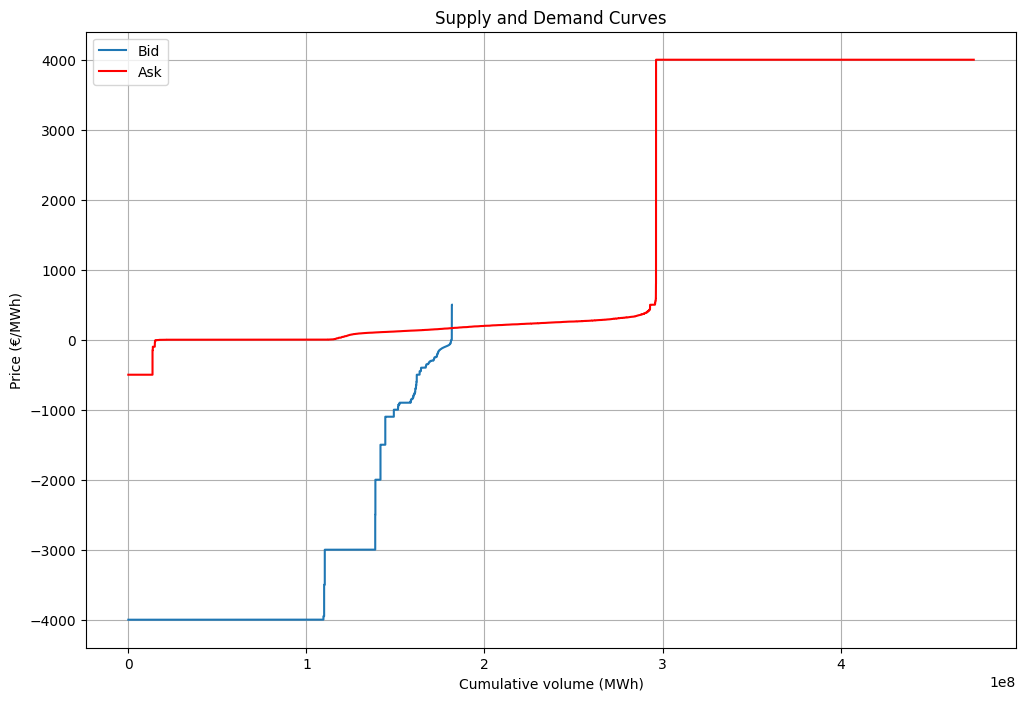

In [317]:
plt.figure(figsize=(12, 8))

plt.step(bid['Cumulative Quantity'], bid['Price'], label='Bid', where='post')
plt.step(ask['Cumulative Quantity'], ask['Price'], label='Ask', color='r', where='post')

plt.title('Supply and Demand Curves')
plt.xlabel('Cumulative volume (MWh)')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.grid(True)

plt.show()

## Smoothening

In [366]:
MAX = 2
alpha = 0.8 

ask = ask.sort_values(by=['Day', 'Hour']).reset_index(drop = True)
ask['Price_Smoothed_Forward'] = ask['Price'].rolling(window=MAX).mean() # by working days
ask['Price_Smoothed_Centered'] = ask['Price'].rolling(window=MAX, center=True).mean() 
ask['Price_Smoothed_EWMA'] = ask['Price'].ewm(alpha=alpha).mean()



bid = bid.sort_values(by=['Day', 'Hour']).reset_index(drop = True)
bid['Price_Smoothed_Forward'] = bid['Price'].rolling(window=MAX).mean() # by working days
bid['Price_Smoothed_Centered'] = bid['Price'].rolling(window=MAX, center=True).mean()
bid['Price_Smoothed_EWMA'] = bid['Price'].ewm(alpha=alpha).mean()



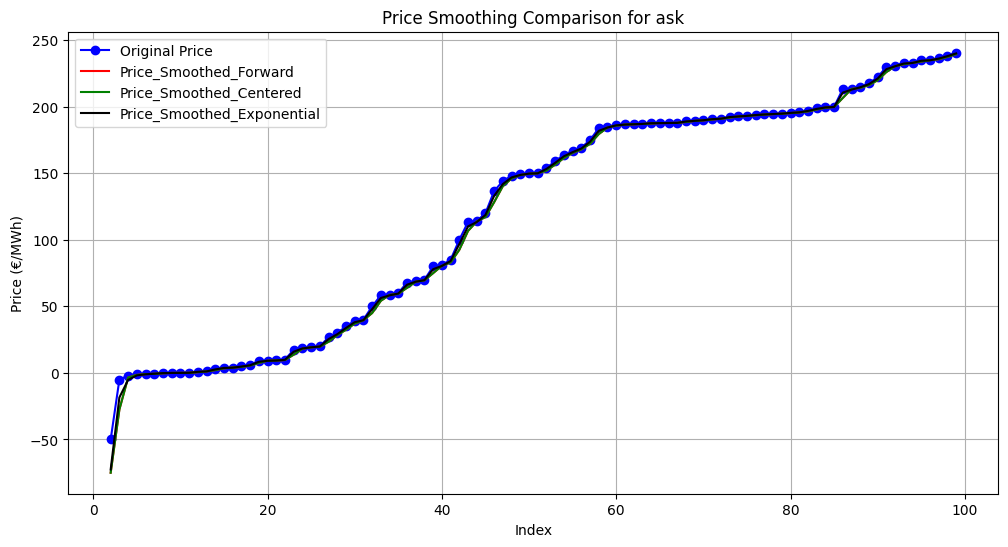

In [369]:
subset = ask.iloc[MAX:100]

plt.figure(figsize=(12, 6))

# Plot original prices
plt.plot(subset.index, subset['Price'], label='Original Price', color='blue', marker='o', linestyle='-')

# plot smooethened prices
plt.plot(subset.index, subset['Price_Smoothed_Forward'], label='Price_Smoothed_Forward', color='red', marker='', linestyle='-')
plt.plot(subset.index, subset['Price_Smoothed_Centered'], label='Price_Smoothed_Centered', color='green', marker='', linestyle='-')
plt.plot(subset.index, subset['Price_Smoothed_EWMA'], label='Price_Smoothed_Exponential', color='black', marker='', linestyle='-')


plt.title('Price Smoothing Comparison for ask')
plt.xlabel('Index')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.grid(True)
plt.show()

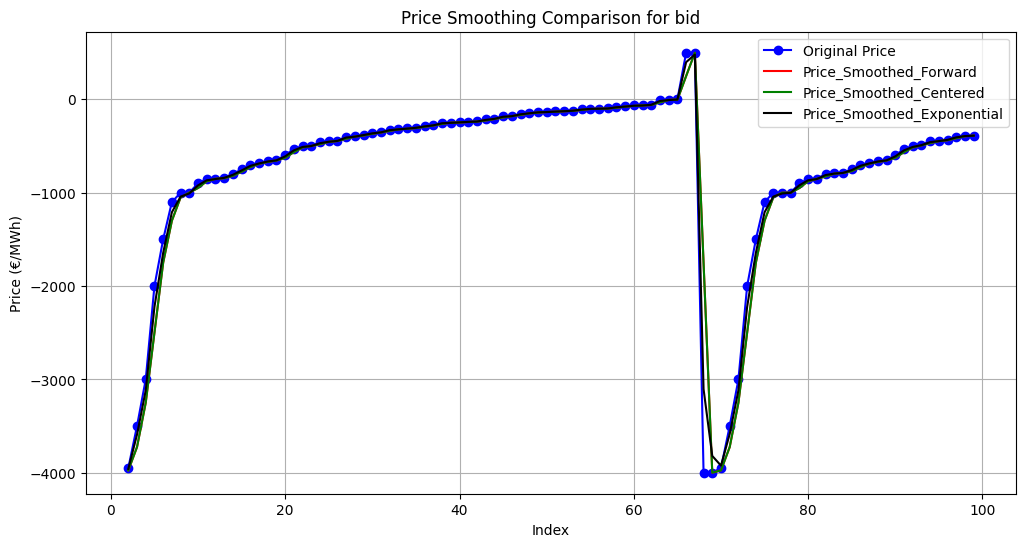

In [370]:
subset = bid.iloc[MAX:100]

plt.figure(figsize=(12, 6))

# Plot original prices
plt.plot(subset.index, subset['Price'], label='Original Price', color='blue', marker='o', linestyle='-')

# plot smooethened prices
plt.plot(subset.index, subset['Price_Smoothed_Forward'], label='Price_Smoothed_Forward', color='red', marker='', linestyle='-')
plt.plot(subset.index, subset['Price_Smoothed_Centered'], label='Price_Smoothed_Centered', color='green', marker='', linestyle='-')
plt.plot(subset.index, subset['Price_Smoothed_EWMA'], label='Price_Smoothed_Exponential', color='black', marker='', linestyle='-')


plt.title('Price Smoothing Comparison for bid')
plt.xlabel('Index')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.grid(True)
plt.show()

In [368]:
# Function to calculate RMSE, ignoring missing values
def calculate_rmse(original, smoothed):
    mask = ~smoothed.isna() 
    return sqrt(mean_squared_error(original[mask], smoothed[mask]))

# ASK dataset
rmse_ask_forward = calculate_rmse(ask['Price'], ask['Price_Smoothed_Forward'])
rmse_ask_centered = calculate_rmse(ask['Price'], ask['Price_Smoothed_Centered'])
rmse_ask_ewma = calculate_rmse(ask['Price'], ask['Price_Smoothed_EWMA'])

# BID dataset
rmse_bid_forward = calculate_rmse(bid['Price'], bid['Price_Smoothed_Forward'])
rmse_bid_centered = calculate_rmse(bid['Price'], bid['Price_Smoothed_Centered'])
rmse_bid_ewma = calculate_rmse(bid['Price'], bid['Price_Smoothed_EWMA'])

print(f"ASK RMSE - Forward: {rmse_ask_forward}, Centered: {rmse_ask_centered}, EWMA: {rmse_ask_ewma}")
print(f"BID RMSE - Forward: {rmse_bid_forward}, Centered: {rmse_bid_centered}, EWMA: {rmse_bid_ewma}")


ASK RMSE - Forward: 144.85960925497406, Centered: 144.85960925497406, EWMA: 54.36693635640756
BID RMSE - Forward: 235.17779606003748, Centered: 235.17779606003748, EWMA: 95.4568488152469


In [372]:
# Function to calculate correlation, ignoring NaN values
def calculate_correlation(original, smoothed):
    return original.corr(smoothed)

# ASK dataset correlations
corr_ask_forward = calculate_correlation(ask['Price'], ask['Price_Smoothed_Forward'])
corr_ask_centered = calculate_correlation(ask['Price'], ask['Price_Smoothed_Centered'])
corr_ask_ewma = calculate_correlation(ask['Price'], ask['Price_Smoothed_EWMA'])

# BID dataset correlations
corr_bid_forward = calculate_correlation(bid['Price'], bid['Price_Smoothed_Forward'])
corr_bid_centered = calculate_correlation(bid['Price'], bid['Price_Smoothed_Centered'])
corr_bid_ewma = calculate_correlation(bid['Price'], bid['Price_Smoothed_EWMA'])

print(f"ASK Correlation - Forward: {corr_ask_forward}, Centered: {corr_ask_centered}, EWMA: {corr_ask_ewma}")
print(f"BID Correlation - Forward: {corr_bid_forward}, Centered: {corr_bid_centered}, EWMA: {corr_bid_ewma}")

ASK Correlation - Forward: 0.8289993668869539, Centered: 0.8289993668869539, EWMA: 0.9828032352241743
BID Correlation - Forward: 0.9610588647182636, Centered: 0.9610588647182636, EWMA: 0.9940294792811378
